In [2]:
# loads path to your input files : base_processed, base_raw, base_models...
%run init_notebook.py

In [3]:
my_data_file = 'dummy_fin_data.csv'

In [4]:
import pandas as pd
# Read the CSV file into a new DataFrame
df = pd.read_csv(base_raw + my_data_file)

# Display the new DataFrame
print(df)

  host pocket     type geography  amount
0  Brs     AV      act        US    1000
1  Brs     AV      act     India      80
2  Brs    liv      2.5       NaN     500
3  Brs    liv  2.5*0.7       NaN     900
4  Frt    PEA      act     world    2900
5  Frt    CTO      act        US     900
6  Lxa     AV      scp       NaN     700


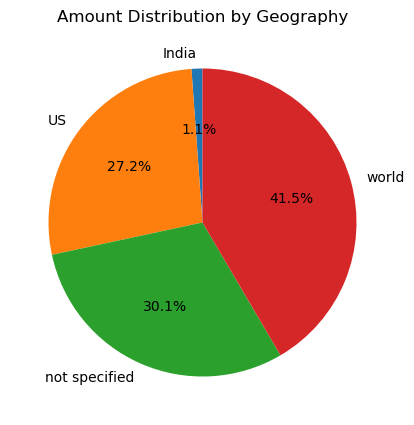

In [ ]:
import matplotlib.pyplot as plt

# Replace NaN values in 'geography' with 'not specified'
df['geography'] = df['geography'].fillna('not specified')

# Group the data by 'geography' and sum the 'amount'
grouped_data = df.groupby('geography')['amount'].sum()

# Define pastel colors
pastel_colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF']

# Create a pie chart with pastel colors
plt.figure(figsize=(5, 5))
grouped_data.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    ylabel='',
    title='Amount Distribution by Geography',
    colors=pastel_colors    # you may want to comment this out to see bright colors instead
)

# Show the plot
plt.show()